In [1]:
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm
import IPython.display as display
import copy
import seaborn as sns

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_1332/1895528008.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shoul

In [2]:
def merge_csv_files(directory):
    # Get a list of all the csv files
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Initialize an empty list to hold dataframes
    dfs = []

    # Loop through csv files, read each into a dataframe, and append to the list
    for file in csv_files:
        # Extract date from filename, assuming the date is in format 'traffic_flow_YYYY_MM_DD'
        date_str = file.split('.')[0].split('_')[-3:]  # This gives ['YYYY', 'MM', 'DD']
        date = datetime.strptime('_'.join(date_str), '%Y_%m_%d').date()

        df = pd.read_csv(os.path.join(directory, file))

        # Add date as a new column
        df['date'] = date.strftime('%m/%d/%y')

        dfs.append(df)

    # Concatenate all dataframes in the list into one dataframe
    merged_df = pd.concat(dfs, ignore_index=True).drop_duplicates()

    # Return the merged dataframe
    return merged_df

In [3]:
traffic_flows = merge_csv_files(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

In [4]:
lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'
inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

# tube_station = gpd.read_file(tube_station)
# tube_station.to_crs(epsg=27700, inplace=True)
# tube_station = gpd.sjoin(tube_station, inoutter, op='within')

tube_line = gpd.read_file(tube_line)
tube_line.to_crs(epsg=27700, inplace=True)
tube_line = gpd.sjoin(tube_line, inoutter, op='within')

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [5]:
# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()
traffic_flows['total'] = traffic_flows['bus'] + traffic_flows['car'] + traffic_flows['cycle'] + traffic_flows[
    'walks'] + traffic_flows['stationary']

In [6]:
flows = pd.merge(
    road_network[['toid', 'roadclassi', 'geometry', 'directiona', 'length', 'roadwidthm', 'elevationg'
                  ]],
    traffic_flows, left_on='toid', right_on='toid', how='right')

flows['classification'] = flows['roadclassi'].replace(
    {'Unknown': 'Local Road', 'Not Classified': 'Local Road', 'Unclassified': 'Local Road',
     'Classified Unnumbered': 'Local Road'})

flows.drop(columns=['roadclassi'], inplace=True)

stage_date = ['03/01/22', '02/22/22', '03/08/22']
flows = flows.loc[flows['date'].isin(stage_date)]

# label the regional level
flows = gpd.sjoin(flows, inoutter, how='inner', predicate='within')
flows = flows.drop(columns=['index_right', 'Source', 'Area_Ha', 'Shape_Leng', 'Shape_Area'])
flows.reset_index(drop=True, inplace=True)

# convert the dataframe
flows = pd.melt(flows,
                id_vars=['toid', 'classification', 'geometry', 'directiona', 'length', 'roadwidthm', 'elevationg',
                         'date', 'Boundary'], var_name='mode', value_name='flow')

flows = pd.pivot_table(flows,
                       index=['toid', 'classification', 'geometry', 'directiona', 'length', 'roadwidthm', 'elevationg',
                              'date', 'Boundary', 'mode'], columns='date', values='flow', aggfunc='first').reset_index()

flows.drop(columns=['date'], inplace=True)
flows = flows.groupby(
    ['toid', 'mode', 'classification', 'geometry', 'directiona', 'length', 'roadwidthm', 'elevationg',
     'Boundary'], as_index=False).agg(
    {'03/01/22': 'first', '02/22/22': 'first', '03/08/22': 'first'})

# calculate the impact and recovery flows for one strike
flows['impact_flow'] = flows['03/01/22'] - flows['02/22/22']
flows['recovery_flow'] = flows['03/08/22'] - flows['03/01/22']



### Take city of  london as an example

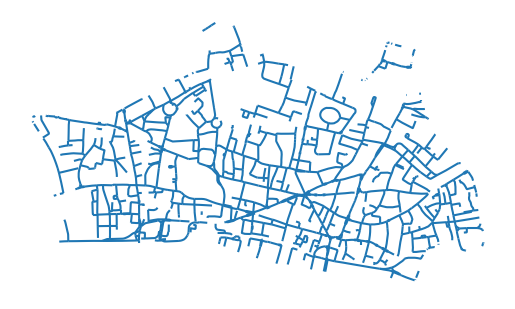

In [44]:
# load the city of london LA
LA = gpd.read_file(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/LA/LA .shp',
    crs={'init': 'epsg:27700'})
CoL = LA.loc[LA['LAD22NM'] == 'City of London']

# spatial clip of the flows data
flows = gpd.GeoDataFrame(flows, geometry='geometry')
CoL_flows = gpd.clip(flows, CoL)

flows = CoL_flows.copy().reset_index(drop=True)

flows.plot()
plt.axis('off')
plt.show()

In [19]:
flows

date,toid,mode,classification,geometry,directiona,length,roadwidthm,elevationg,Boundary,03/01/22,02/22/22,03/08/22,impact_flow,recovery_flow
0,osgb4000000030240531,total,Local Road,"LINESTRING (533321.192 180599.436, 533342.643 ...",bothDirections,87.38,6.3m,0m,Inner London,349.0,766.0,299.0,-417.0,-50.0
1,osgb5000005129680299,total,Local Road,"LINESTRING (533314.713 180602.100, 533321.192 ...",bothDirections,7.01,8.5m,0m,Inner London,291.0,640.0,248.0,-349.0,-43.0
2,osgb4000000030995709,total,Local Road,"MULTILINESTRING ((533405.162 180572.986, 53340...",bothDirections,68.71,4.1m,4.1m,Inner London,90.0,266.0,117.0,-176.0,27.0
3,osgb5000005129680319,total,Local Road,"LINESTRING (533308.915 180604.484, 533314.713 ...",bothDirections,6.27,9.5m,0m,Inner London,317.0,660.0,276.0,-343.0,-41.0
4,osgb4000000031267675,total,Local Road,"LINESTRING (533266.000 180622.000, 533308.915 ...",bothDirections,46.35,7m,0m,Inner London,28.0,51.0,18.0,-23.0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,osgb4000000030344971,total,Local Road,"LINESTRING (532250.312 182187.436, 532251.946 ...",bothDirections,29.79,10m,0m,Inner London,43.0,17.0,46.0,26.0,3.0
1244,osgb4000000030419462,total,Local Road,"LINESTRING (532110.000 182190.000, 532093.000 ...",bothDirections,25.28,7m,0.1m,Inner London,17.0,16.0,12.0,1.0,-5.0
1245,osgb4000000030419463,total,Local Road,"LINESTRING (532109.915 182190.124, 532110.000 ...",bothDirections,23.02,3.5m,0m,Inner London,11.0,5.0,8.0,6.0,-3.0
1246,osgb4000000030419464,total,Local Road,"LINESTRING (532134.758 182205.325, 532110.000 ...",bothDirections,29.11,7.1m,0.1m,Inner London,17.0,10.0,15.0,7.0,-2.0


### K-means clustering

In [20]:
# from sklearn.cluster import KMeans
# 
# # Group the DataFrame by unique values in 'mode' column
# grouped = flows.groupby('mode')
# 
# # Perform KMeans clustering for each group separately
# for mode, group in grouped:
#     kmeans = KMeans(n_clusters=3, random_state=42)
#     flows.loc[group.index, 'KmeansBymode_impact'] = kmeans.fit_predict(group[['impact_flow']])
#     flows.loc[group.index, 'KmeansBymode_recovery'] = kmeans.fit_predict(group[['recovery_flow']])
# 


In [21]:
# # Create a scatter plot to visualize 'KmeansBymode_impact' and its clustering results
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=flows, x='KmeansBymode_impact', y='impact_flow', hue='mode', palette='tab10', s=100)
# plt.title('KMeans Clustering for Different Modes')
# plt.xlabel('KmeansBymode_impact')
# plt.ylabel('Impact Flow')
# plt.legend(title='Mode', loc='upper right', bbox_to_anchor=(1.15, 1.0))
# plt.show()


In [22]:
# def visualize_kmeans_by_mode_and_classification(flows, feature1, feature2):
#     """
#     Visualize KMeans clustering results for different 'mode' and 'classification' categories.
# 
#     Parameters:
#         flows (DataFrame): The DataFrame containing the data.
#         feature1 (str): The name of the first feature to visualize KMeans clusters.
#         feature2 (str): The name of the second feature to visualize KMeans clusters.
# 
#     Returns:
#         None
#     """
# 
#     # Create a new column to store the combined KMeans cluster labels
#     flows['KmeansByModeAndClassification'] = None
# 
#     # Group the DataFrame by unique values in 'mode' column
#     grouped_by_mode = flows.groupby('mode')
# 
#     # Perform KMeans clustering for each 'mode' group separately
#     for mode, group_mode in grouped_by_mode:
#         kmeans = KMeans(n_clusters=3, random_state=42)
#         flows.loc[group_mode.index, 'KmeansByModeAndClassification'] = kmeans.fit_predict(group_mode[[feature1, feature2]])
# 
#         # Create subplots for each 'classification' category
#         plt.figure(figsize=(8, 6))
#         sns.scatterplot(data=flows.loc[group_mode.index], x=feature1, y=feature2, hue='KmeansByModeAndClassification', palette='tab10', s=100)
#         plt.title(f'KMeans Clustering for {mode} Mode')
#         plt.xlabel(feature1)
#         plt.ylabel(feature2)
#         plt.legend(title='KMeans Cluster')
#         plt.show()
# 
# # Call the visualization method
# visualize_kmeans_by_mode_and_classification(flows, 'impact_flow', 'recovery_flow')


In [23]:
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# # 假设你的DataFrame名为flows，包含'mode'、'toid'、'classification'和'impact_flow'等列
# 
# # 定义分类顺序
# classification_order = ['Motorway', 'A Road', 'B Road', 'Local Road']
# mode_order = ['total', 'car', 'bus', 'cycle', 'walks', 'stationary']
# 
# # 使用pivot_table将'mode'作为列，'classification'作为行，'impact_flow'作为值，并进行求和（sum）
# flows_pivot = pd.pivot_table(flows, index='classification', columns='mode', values='impact_flow', aggfunc='sum')
# 
# # 对DataFrame进行排序，以调整顺序
# flows_pivot = flows_pivot.reindex(classification_order, axis=0)
# flows_pivot = flows_pivot[mode_order]
# 
# # 对impact_flow取对数
# flows_pivot = np.log(flows_pivot)
# 
# # 绘制条形图
# plt.figure(figsize=(10, 6))
# flows_pivot.plot(kind='bar', ax=plt.gca())
# plt.title('Impact Flow by Classification and Mode')
# plt.xlabel('Classification')
# plt.ylabel('Impact Flow')
# plt.legend(title='Mode', loc='upper right', bbox_to_anchor=(1.15, 1.0))
# plt.show()


In [24]:
# # 定义分类顺序和模式顺序
# classification_order = ['Motorway', 'A Road', 'B Road', 'Local Road']
# mode_order = ['total', 'car', 'bus', 'cycle', 'walks', 'stationary']
# 
# # 使用pivot_table将'mode'作为列，'classification'作为行，'impact_flow'作为值，并进行求和（sum）
# flows_pivot = pd.pivot_table(flows, index='classification', columns='mode', values='impact_flow', aggfunc='sum')
# 
# # 对DataFrame进行排序，以调整顺序
# flows_pivot = flows_pivot.reindex(classification_order, axis=0)
# flows_pivot = flows_pivot[mode_order]
# 
# # 对impact_flow取对数
# flows_pivot_log = np.log(flows_pivot)
# 
# # 根据'KmeansBymode_impact'列的值将flows DataFrame分为两部分
# flows_impact_1 = flows[flows['KmeansBymode_impact'] == 1]
# flows_impact_0 = flows[flows['KmeansBymode_impact'] == 0]
# 
# # 将flows DataFrame转换为geopandas GeoDataFrame
# gdf_impact_1 = gpd.GeoDataFrame(flows_impact_1, geometry='geometry')
# gdf_impact_0 = gpd.GeoDataFrame(flows_impact_0, geometry='geometry')
# 
# # 绘制空间可视化
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_impact_1.plot(ax=ax, color='red', legend=True, markersize='impact_flow', label='KmeansBymode_impact = 1')
# gdf_impact_0.plot(ax=ax, color='blue', legend=True, markersize='impact_flow', label='KmeansBymode_impact = 0')
# plt.title('Spatial Visualization of Flows')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title='KmeansBymode_impact', loc='upper right', bbox_to_anchor=(1.15, 1.0))
# plt.show()


### Graph

In [171]:
flows = flows[flows['mode'] == 'total']
flows.reset_index(drop=True)

# Create an empty graph
graph = nx.Graph()

In [172]:
# creat a blank graph
graph = nx.Graph()

# iterate over the rows of the flows DataFrame
for _, row in flows.iterrows():
    geometry = row['geometry']
    baseline_1 = row['02/22/22']
    strike_1 = row['03/01/22']
    recovery_1 = row['03/08/22']
    impact_flow = row['impact_flow']
    recovery_flow = row['recovery_flow']
    direction = row['directiona']

    # break the MultiLineString geometry into its constituent LineStrings
    if geometry.geom_type == 'MultiLineString':
        for line_string in geometry.geoms:  # iterate over each LineString
            from_node = line_string.coords[0]
            to_node = line_string.coords[-1]

            # Add nodes to the graph
            graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
            graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
            # Add edges to the graph based on the direction
            if direction == 'bothDirections':
                # If the road is bidirectional, flows are split equally in both directions
                graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                               recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
                graph.add_edge(to_node,
                               from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2, recovery_1=recovery_1 / 2,
                               impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
            elif direction == 'inOppositeDirection':
                # If the road is in the opposite direction, flows are from the ending point to the starting point
                graph.add_edge(to_node,
                               from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2, recovery_1=recovery_1 / 2,
                               impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
            elif direction == 'inDirection':
                # If the road is in the same direction, flows are from the starting point to the ending point
                graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                               recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                               toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
    else:
        from_node = geometry.coords[0]
        to_node = geometry.coords[-1]

        # Add nodes to the graph
        graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
        graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
        # Add edges to the graph based on the direction
        if direction == 'bothDirections':
            # If the road is bidirectional, flows are split equally in both directions
            graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                           recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                           toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
            graph.add_edge(to_node, from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                           recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                           toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
        elif direction == 'inOppositeDirection':
            # If the road is in the opposite direction, flows are from the ending point to the starting point
            graph.add_edge(to_node, from_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                           recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                           toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
        elif direction == 'inDirection':
            # If the road is in the same direction, flows are from the starting point to the ending point
            graph.add_edge(from_node, to_node, baseline_1=baseline_1 / 2, strike_1=strike_1 / 2,
                           recovery_1=recovery_1 / 2, impact_flow=impact_flow / 2, recovery_flow=recovery_flow / 2,
                           toid=row['toid'], classification=row['classification'], geometry=row['geometry'])


In [173]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


def graph_visualization(graph, weight=None, cmap='Greens'):
    # obtain all the edges in the graph
    edges_list = list(graph.edges())

    # make sure the graph is not empty
    if edges_list:
        # obtain the start and end coordinates of the first edge
        u, v = edges_list[0]

        # obtain the edge attribute of the first edge
        edge_attr = graph[u][v]

        print(f"The first edge: ({u}, {v})")
        print("Attribute: ", edge_attr)
    else:
        print("No edge in the graph.")

    # get the node positions
    node_positions = nx.get_node_attributes(graph, 'pos')

    # get the edge weights
    edge_weight = nx.get_edge_attributes(graph, weight)

    # normalize the edge weights between 0 and 1
    weight_values = list(edge_weight.values())
    norm = Normalize(vmin=min(weight_values), vmax=max(weight_values))
    norm_weight = {edge: norm(weight) for edge, weight in edge_weight.items()}

    # create a colormap
    cmap_object = plt.get_cmap(cmap)
    mappable = ScalarMappable(norm=norm, cmap=cmap_object)
    mappable.set_array([])

    # plot the graph
    fig, ax = plt.subplots()
    nx.draw_networkx_edges(graph, pos=node_positions, edge_color='gray')
    nx.draw_networkx_edges(graph, pos=node_positions,
                           edge_color=[mappable.to_rgba(norm_weight[edge]) for edge in edges_list])

    # add a colorbar
    cbar = plt.colorbar(mappable, ax=ax, orientation='horizontal', pad=0.01)
    cbar.set_label(weight)

    plt.title(f'Graph Representation of the Road Network', size=10)
    plt.axis('off')
    plt.show()

The first edge: ((533321.1919999998, 180599.43610000052), (533401.6511740354, 180569.5704318664))
Attribute:  {'baseline_1': 383.0, 'strike_1': 174.5, 'recovery_1': 149.5, 'impact_flow': -208.5, 'recovery_flow': -25.0, 'toid': 'osgb4000000030240531', 'classification': 'Local Road', 'geometry': <LINESTRING (533321.192 180599.436, 533342.643 180590.615, 533342.846 180590...>}


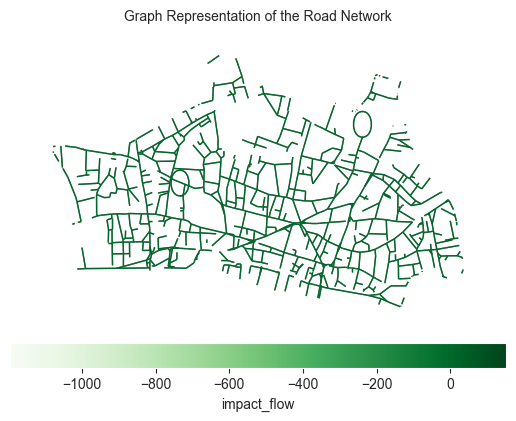

The first edge: ((533321.1919999998, 180599.43610000052), (533401.6511740354, 180569.5704318664))
Attribute:  {'baseline_1': 383.0, 'strike_1': 174.5, 'recovery_1': 149.5, 'impact_flow': -208.5, 'recovery_flow': -25.0, 'toid': 'osgb4000000030240531', 'classification': 'Local Road', 'geometry': <LINESTRING (533321.192 180599.436, 533342.643 180590.615, 533342.846 180590...>}


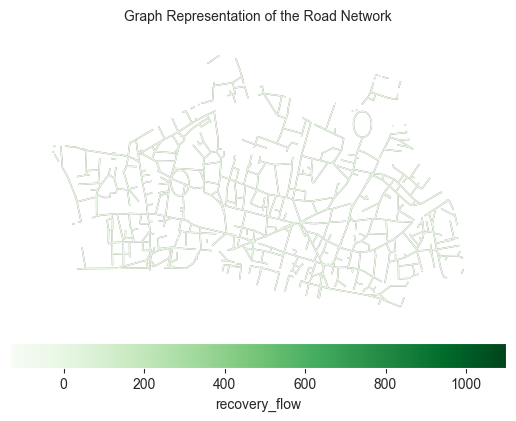

In [175]:
graph_visualization(graph, weight='impact_flow')
graph_visualization(graph, weight='recovery_flow')

#### Calculate the structure-based indicators for roads and system


In [178]:
# calculate the number of nodes
nodes_number = graph.number_of_nodes()

# calculate the number of edges
links_number = graph.number_of_edges()

# calculate the total link weight
total_link_weight = sum([data['impact_flow'] for u, v, data in graph.edges(data=True)])

mean_link_weight = total_link_weight / links_number

# calculate the coefficient of variation of node degree
node_degrees = dict(graph.degree())
mean_node_degree = np.mean(list(node_degrees.values()))
std_node_degree = np.std(list(node_degrees.values()))
node_degree_cv = (std_node_degree / mean_node_degree) * 100

# calculate the coefficient of variation of edge weight
edge_weights = nx.get_edge_attributes(graph, 'impact_flow').values()
mean_edge_weight = np.mean(list(edge_weights))
std_edge_weight = np.std(list(edge_weights))
edge_weight_cv = (std_edge_weight / mean_edge_weight) * 100

# calculate the network connectivity and score for graph
network_connectivity = nx.is_connected(graph)
connectivity_score = 2 * links_number / (nodes_number * nodes_number)

# calculate the average clustering coefficient for graph
avg_clustering_coefficient = nx.average_clustering(graph)

# calculate the transitivity for graph
transitivity = nx.transitivity(graph)

# calculate the assortativity for graph
assortativity = nx.degree_assortativity_coefficient(graph)

# calculate indicators as attributes for each road
clustering_coefficients = nx.clustering(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph)

# calculate the node degrees
node_degrees = graph.degree()

# calculate the average degree for graph
average_degree = sum(dict(node_degrees).values()) / len(node_degrees)

# calculate the betweenness_centrality for each road
betweenness_centrality = nx.betweenness_centrality(graph)


# Add the calculated indicators as attributes for each road
for u, v in graph.edges():
    edge_clustering_coefficient = (clustering_coefficients[u] + clustering_coefficients[v]) / 2
    graph[u][v]['clustering_coefficient'] = edge_clustering_coefficient

    graph[u][v]['degree'] = (node_degrees[u] + node_degrees[v]) / 2
    graph[u][v]['betweenness'] = (betweenness_centrality[u] + betweenness_centrality[v]) / 2

    edge_eigenvector_centrality = (eigenvector_centrality[u] + eigenvector_centrality[v]) / 2
    graph[u][v]['eigenvector_centrality'] = edge_eigenvector_centrality

# Print the calculated indicators
print("Total Nodes Number:", nodes_number)
print("Total Links Number:", links_number)
print("Total Flows:", round(total_link_weight))
print("Mean Link Flow:", mean_link_weight)
print("Node Degree Coefficient of Variation:", node_degree_cv)
print("Edge Weight Coefficient of Variation:", edge_weight_cv)
print("Connectivity Score:", connectivity_score)
print("Network Connectivity:", network_connectivity)
print("Transitivity:", transitivity)
print("Assortativity:", assortativity)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Average Degree:", average_degree)
print("Average Betweenness Centrality:", sum(betweenness_centrality.values()) / len(betweenness_centrality))


Total Nodes Number: 1104
Total Links Number: 1227
Total Flows: -36378
Mean Link Flow: -29.64832925835371
Node Degree Coefficient of Variation: 43.64719788169159
Edge Weight Coefficient of Variation: -449.4150053013593
Connectivity Score: 0.002013429426591052
Network Connectivity: False
Transitivity: 0.06405163853028799
Assortativity: 0.03229002749195224
Average Clustering Coefficient: 0.03592995169082128
Average Degree: 2.222826086956522
Average Betweenness Centrality: 0.0141694866290193


impact_flow复原性和脆弱性分析：

**复原性分析：**
- **Total Nodes Number: 1104** 和 **Total Links Number: 1227** 表示路网的规模。规模较大可能需要更多资源来维护，但在复原性方面，如果网络中有多个节点和连接，也可能有更多的备选路径。

- **Total Flows: -36378** 和 **Mean Link Flow: -29.65** 表示流量变化差值和平均链路流量。负数的流量变化差值可能表示流量减少。这可能会导致某些连接拥塞或资源分配不当，对于复原性可能带来一些挑战。

- **Node Degree Coefficient of Variation: 43.65** 和 **Edge Weight Coefficient of Variation: -449.42** 表示节点度数和边权重的变异程度。负的边权重变异系数可能反映了权重值的分布不均匀。较高的节点度数变异系数可能意味着一些节点的连接更为密集，但是这种变异可能影响网络的复原性。

- **Transitivity: 0.064** 表示节点的传递性。传递性的增加可能有助于信息或流量在网络中的快速传播，提高复原性。

- **Assortativity: 0.032** 表示网络的度同配性。这种度同配性可能有助于信息在网络中传播，但是取值较低，作用可能不太明显。

**脆弱性分析：**
- **Connectivity Score: 0.00201** 和 **Network Connectivity: False** 表示连接性分数较低和网络不是全连通的。这可能意味着网络中可能存在一些孤立的区域，当这些区域受到影响时，整个网络的连通性会受到影响。

- **Average Clustering Coefficient: 0.036** 表示平均聚类系数。较低的聚类系数可能意味着节点之间关联性不高，可能导致信息难以在网络中传播。

- **Average Betweenness Centrality: 0.014** 表示平均介数中心性，较低的介数中心性可能表示网络中的信息流和影响受限。

综合分析，以流量变化差值为权重的城市伦敦路网结构可能具有一定的复原性挑战和脆弱性。负数的流量变化可能表明某些区域可能存在拥塞或资源分配不足。节点度数和边权重的变异可能意味着网络中存在一些密集连接的节点和不均匀的权重分布，这可能会影响网络的鲁棒性。然而，一些正向因素如传递性、度同配性等可能有助于信息传播和一些程度的复原。在增强路网的复原性和脆弱性方面，可能需要考虑网络的连通性、资源分配、信息传播等因素。

**Strike_1复原性分析：**
- **Total Nodes Number: 1104** 和 **Total Links Number: 1227** 表示路网的规模。路网的大小可能对于复原性有影响，大规模路网可能需要更多的资源来维持。

- **Node Degree Coefficient of Variation: 43.65** 和 **Edge Weight Coefficient of Variation: 115.01** 表示节点度数和边权重的变异程度。较高的变异系数可能意味着部分节点度数和边权重变化较大，这可能增加了复原过程的难度，因为某些节点或边更容易受到影响。

- **Transitivity: 0.064** 表示节点的传递性。传递性的增加可能有助于信息或流量在网络中的快速传播，这对复原性可能有积极影响。

- **Assortativity: 0.032** 表示网络的度同配性，即高度连接的节点倾向于连接到其他高度连接的节点。这种连接模式可能有助于信息在网络中传播，从而提高复原性。

**脆弱性分析：**
- **Network Connectivity: False** 表示网络不是全连通的，可能存在多个网络组件。这可能导致某些区域或网络组件受到故障影响时，整个网络的连通性受到影响。

- **Connectivity Score: 0.00201** 表示网络的连接性分数较低。低连接性分数可能意味着网络中的连接较弱，复原能力较弱。

- **Average Clustering Coefficient: 0.036** 表示平均聚类系数。较低的聚类系数可能表示节点之间的关联性不高，网络的鲁棒性可能较弱。

- **Average Betweenness Centrality: 0.014** 表示平均介数中心性，介数中心性衡量节点在网络中作为桥梁的程度。较低的介数中心性可能意味着网络中的信息流和影响可能受限。

综合分析，CoL路网结构可能具有一定的复原性挑战和脆弱性。较高的节点度数和边权重变异系数、低连接性分数、不高的平均聚类系数和介数中心性可能意味着在面对故障、拥塞、攻击等情况时，网络的复原能力可能受到一定影响。但是，度同配性、传递性等正向因素可能有助于一些程度上的复原和信息传播。为了增强路网的复原性和脆弱性，可能需要关注网络连接性、鲁棒性、信息传播能力等方面的改进。

The first edge: ((533321.1919999998, 180599.43610000052), (533401.6511740354, 180569.5704318664))
Attribute:  {'flow': 174.5, 'toid': 'osgb4000000030240531', 'classification': 'Local Road', 'geometry': <LINESTRING (533321.192 180599.436, 533342.643 180590.615, 533342.846 180590...>, 'clustering_coefficient': 0.0, 'degree': 1.5, 'betweenness': 0.0006927156262494797, 'eigenvector_centrality': 6.966620726151443e-08}


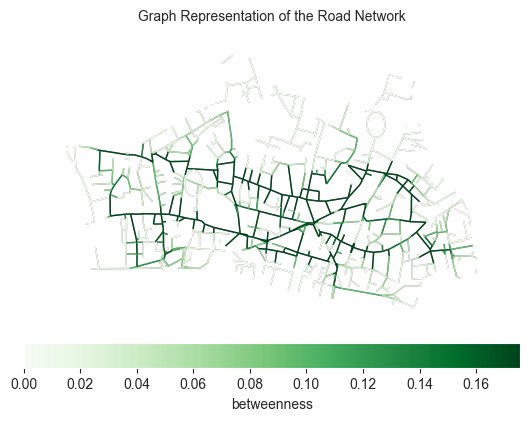

The first edge: ((533321.1919999998, 180599.43610000052), (533401.6511740354, 180569.5704318664))
Attribute:  {'flow': 174.5, 'toid': 'osgb4000000030240531', 'classification': 'Local Road', 'geometry': <LINESTRING (533321.192 180599.436, 533342.643 180590.615, 533342.846 180590...>, 'clustering_coefficient': 0.0, 'degree': 1.5, 'betweenness': 0.0006927156262494797, 'eigenvector_centrality': 6.966620726151443e-08}


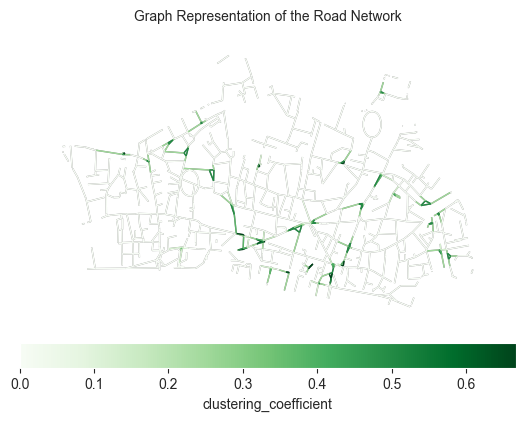

The first edge: ((533321.1919999998, 180599.43610000052), (533401.6511740354, 180569.5704318664))
Attribute:  {'flow': 174.5, 'toid': 'osgb4000000030240531', 'classification': 'Local Road', 'geometry': <LINESTRING (533321.192 180599.436, 533342.643 180590.615, 533342.846 180590...>, 'clustering_coefficient': 0.0, 'degree': 1.5, 'betweenness': 0.0006927156262494797, 'eigenvector_centrality': 6.966620726151443e-08}


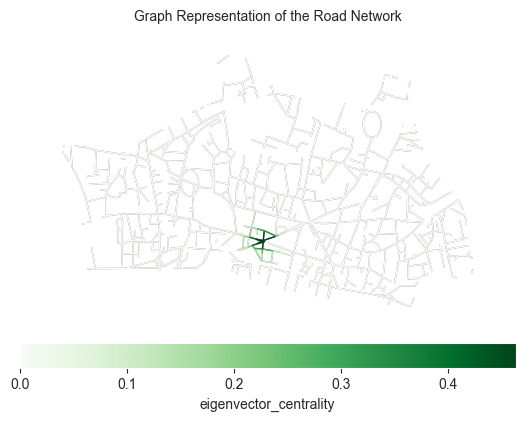

In [170]:
graph_visualization(graph, weight='betweenness')
graph_visualization(graph, weight='clustering_coefficient')
graph_visualization(graph, weight='eigenvector_centrality')